# Emulating steady state boundary layer growth

In [1]:
import underworld3 as uw
import sympy
import mpi4py

In [2]:
U = 1 ## velocitiy of the main flow

In [3]:
mesh = uw.meshing.UnstructuredSimplexBox(minCoords=(0,0), maxCoords=(2,2), cellSize=1/20, qdegree=3)

##  degree should be v > p
v = uw.discretisation.MeshVariable("U", mesh, mesh.dim, degree=2)
p = uw.discretisation.MeshVariable("P", mesh, 1, degree=1)

stokes = uw.systems.Stokes(mesh, velocityField=v, pressureField=p)
stokes.constitutive_model = uw.systems.constitutive_models.ViscousFlowModel(mesh.dim)
stokes.constitutive_model.Parameters.viscosity = 1


##body_force_function = mesh.vector.divergence(v.sym) * v.sym
body_force_function = (mesh.vector.jacobian(v.sym.T) * v.sym.T).T
##body_force_function = sympy.Matrix([0, 0])

##body_force_function = mesh.vector.jaco

x,y = mesh.X
bottom = sympy.Piecewise(
    (U, x < 1),
    (0, True)

)

stokes.add_dirichlet_bc( (0, 0), "Bottom", (0, 1) )
stokes.add_dirichlet_bc( (U, 0), "Left", (0, 1) )

stokes.add_dirichlet_bc( (U, 0), "Top", (0))


stokes.bodyforce = body_force_function
body_force_function










Matrix([[U_{ 0 }(N.x, N.y)*U_{ 0,0}(N.x, N.y) + U_{ 0,1}(N.x, N.y)*U_{ 1 }(N.x, N.y), U_{ 0 }(N.x, N.y)*U_{ 1,0}(N.x, N.y) + U_{ 1 }(N.x, N.y)*U_{ 1,1}(N.x, N.y)]])

In [4]:
stokes


This class provides functionality for a discrete representation
of the Stokes flow equations assuming an incompressibility
(or near-incompressibility) constraint.

$$\frac{\partial}{\partial x_j} \left( \frac{\eta}{2} \left[ \frac{\partial u_i}{\partial x_j}  +
        \frac{\partial u_j}{\partial x_i} \right]\right) - \frac{\partial p}{\partial x_i} = f_i$$

$$\frac{\partial u_i}{\partial x_i} = 0$$

## Properties

  - The viscosity, $ \eta $ is provided by setting the `constitutive_model` property to
one of the `uw.systems.constitutive_models` classes and populating the parameters.
It is usually a constant or a function of position / time and may also be non-linear
or anisotropic.

  - The bodyforce term, $ f_i $ is provided through the `bodyforce` property.

  - The Augmented Lagrangian approach to application of the incompressibility
constraint is to penalise incompressibility in the Stokes equation by adding
$ \lambda \nabla \cdot \mathbf{u} $ when the weak form of the equations is constructed.
(this is in addition to the constraint equation, unlike in the classical penalty method).
This is activated by setting the `penalty` property to a non-zero floating point value.

  - A preconditioner is usually required for the saddle point system and this is provided
though the `saddle_preconditioner` property. A common choice is $ 1/ \eta $ or
$ 1 / \eta + 1/ \lambda $ if a penalty is used


## Notes

  - The interpolation order of the `pressureField` variable is used to determine the integration order of
the mixed finite element method and is usually lower than the order of the `velocityField` variable.

  - It is possible to set discontinuous pressure variables by setting the `p_continous` option to `False`
(currently this is not implemented).

  - The `solver_name` parameter sets the namespace for PETSc options and should be unique and
compatible with the PETSc naming conventions.




This solver is formulated in 2 dimensions

In [5]:
##with mesh.access(v):
    ##v.data[:, 0] = 1
    ##v.data[:, 1] = 2

In [6]:
stokes.tolerance = 0.001

In [7]:
stokes.petsc_options.getAll()

{'_pprivate_petscdualspace_lagrange_continuity': 'true',
 '_pprivate_petscdualspace_lagrange_node_endpoints': 'false',
 '_pprivate_petscspace_degree': '1',
 '_uprivate_petscspace_degree': '2',
 'fieldsplit_pressure_ksp_rtol': '0.0001',
 'fieldsplit_pressure_ksp_type': 'fgmres',
 'fieldsplit_pressure_pc_gasm_type': 'basic',
 'fieldsplit_pressure_pc_type': 'gasm',
 'fieldsplit_velocity_ksp_rtol': '0.0001',
 'fieldsplit_velocity_ksp_type': 'cg',
 'fieldsplit_velocity_mg_levels_ksp_converged_maxits': None,
 'fieldsplit_velocity_mg_levels_ksp_max_it': '3',
 'fieldsplit_velocity_pc_gamg_agg_nsmooths': '2',
 'fieldsplit_velocity_pc_gamg_repartition': 'true',
 'fieldsplit_velocity_pc_gamg_type': 'agg',
 'fieldsplit_velocity_pc_mg_type': 'additive',
 'fieldsplit_velocity_pc_type': 'gamg',
 'ksp_atol': '1e-09',
 'ksp_rtol': '1e-06',
 'pc_fieldsplit_diag_use_amat': None,
 'pc_fieldsplit_off_diag_use_amat': None,
 'pc_fieldsplit_schur_fact_type': 'full',
 'pc_fieldsplit_schur_precondition': 'a11',

In [8]:

"""
import concurrent.futures
import time

def my_function(a, body_force_function):
    stokes.bodyforce = a * body_force_function
    return stokes.solve(zero_init_guess=False)

def nonLinearSolve(multiStep, start):
    a = start
    while a != 1:
        print("trying a:", a)
        status = ""
        with concurrent.futures.ThreadPoolExecutor() as executor:
            future = executor.submit(my_function, a, body_force_function)
            try:
                status = future.result(timeout=20)
            except concurrent.futures.TimeoutError:
                print("timed out")
                status = "timeout"
        print("here is status:", status)
        if status == "timeout":
            a = a / (1 + multiStep)
            multiStep = multiStep / 2
        elif status < 0:
            a = start
            multiStep = multiStep / 2
        elif status >= 0:
            a = a * (1 +  multiStep)
        if a > 1:
            a = 1






import signal
import time

def timeout_handler(num, stack):
    print("Received SIGALRM")
    raise Exception("TIMEOUT")



def nonLinearSolve(multiStep, start):
    a = start
    while a != 1:
        print("trying a:", a)
        signal.signal(signal.SIGALRM, timeout_handler)
        signal.alarm(10)
        stokes.bodyforce = a * body_force_function
        status = ""
        try:
            status = stokes.solve()
        except Exception as ex:
            print("timed out")
            status = "timeout"
        finally:
            signal.alarm(0)
        print("here is status:", status)
        if (status == "timeout"):
            ## do nothing
            a = a/(1 + multiStep)
            multiStep = multiStep/2
        elif (status < 0):
            a = start
            multiStep = multiStep/2
        elif (status >= 0):
            a = a * (1 +  multiStep)

        if (a > 1):
            a = 1
    """
    
        

        
        

'\nimport concurrent.futures\nimport time\n\ndef my_function(a, body_force_function):\n    stokes.bodyforce = a * body_force_function\n    return stokes.solve(zero_init_guess=False)\n\ndef nonLinearSolve(multiStep, start):\n    a = start\n    while a != 1:\n        print("trying a:", a)\n        status = ""\n        with concurrent.futures.ThreadPoolExecutor() as executor:\n            future = executor.submit(my_function, a, body_force_function)\n            try:\n                status = future.result(timeout=20)\n            except concurrent.futures.TimeoutError:\n                print("timed out")\n                status = "timeout"\n        print("here is status:", status)\n        if status == "timeout":\n            a = a / (1 + multiStep)\n            multiStep = multiStep / 2\n        elif status < 0:\n            a = start\n            multiStep = multiStep / 2\n        elif status >= 0:\n            a = a * (1 +  multiStep)\n        if a > 1:\n            a = 1\n\n\n\n\n\n\

In [9]:
import sympy
for a in [1,5,10]:
    stokes.bodyforce = a * body_force_function
    stokes.solve(zero_init_guess=False)
    

  0 SNES Function norm 32.2125 
  1 SNES Function norm 0.135156 
  2 SNES Function norm 0.00486099 
Nonlinear Stokes_1_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 2


In [ ]:
##nonLinearSolve(9, 0.00001)

In [ ]:
if mpi4py.MPI.COMM_WORLD.size == 1:
    import numpy as np
    import pyvista as pv
    import vtk
    
    pv.start_xvfb()
    pv.global_theme.background = "white"
    pv.global_theme.window_size = [750, 1200]
    pv.global_theme.antialiasing = True
    pv.global_theme.jupyter_backend = "panel"
    pv.global_theme.smooth_shading = True
    mesh.vtk("tmp_mesh.vtk")
    pvmesh = pv.read("tmp_mesh.vtk")
    pvmesh.point_data["P"] = uw.function.evaluate(p.sym[0], mesh.data)
    pvmesh.point_data["V"] = uw.function.evaluate( (v.sym.dot(v.sym))**0.5, mesh.data)
    pvmesh.point_data["Vx"] = uw.function.evaluate( v.sym[0], mesh.data)
    arrow_loc = np.zeros((stokes.u.coords.shape[0], 3))
    arrow_loc[:, 0:2] = stokes.u.coords[...]
    arrow_length = np.zeros((stokes.u.coords.shape[0], 3))
    ##arrow_length[:, 0] = uw.function.evaluate(stokes.u.sym[0], stokes.u.coords)*0.05
    ##arrow_length[:, 1] = uw.function.evaluate(stokes.u.sym[1], stokes.u.coords)*0.05
    pl = pv.Plotter(window_size=[1000, 1000])
    pl.add_axes()
    pl.add_mesh(
        pvmesh,
        cmap="coolwarm",
        edge_color="Black",
        show_edges=True,
        scalars="Vx",
        use_transparency=False,
        opacity=1.0,
    )
    pl.add_arrows(arrow_loc, arrow_length, mag=3)
    
    pl.screenshot("flowInPipe.png")
    pl.show(cpos="xy")

/Users/maxwilliams/anaconda3/envs/uw3/lib/python3.10/site-packages/pyvista/themes.py:2577: PyVistaDeprecationWarning: antialising is deprecated.  Please use `anti_aliasing` instead.
  warnings.warn(
/Users/maxwilliams/anaconda3/envs/uw3/lib/python3.10/site-packages/pyvista/themes.py:2545: PyVistaDeprecationWarning: `anti_aliasing` is now a string or None and must be either "ssaa", "msaa", "fxaa", or None
  warnings.warn(


/var/folders/s9/rd03rq4x0px79z1jnyqlz3540000gn/T/ipykernel_72415/3929646840.py:10: PyVistaDeprecationWarning: `panel` backend is deprecated and is planned for future removal.
  pv.global_theme.jupyter_backend = "panel"


BokehModel(combine_events=True, render_bundle={'docs_json': {'f0356f0a-54b6-4b4c-b288-3d851d920b36': {'version…

In [ ]:
if mpi4py.MPI.COMM_WORLD.size == 1:
    import numpy as np
    import pyvista as pv
    import vtk
    
    pv.start_xvfb()
    pv.global_theme.background = "white"
    pv.global_theme.window_size = [750, 1200]
    pv.global_theme.antialiasing = True
    pv.global_theme.jupyter_backend = "panel"
    pv.global_theme.smooth_shading = True
    mesh.vtk("tmp_mesh.vtk")
    pvmesh = pv.read("tmp_mesh.vtk")
    pvmesh.point_data["P"] = uw.function.evaluate(p.sym[0], mesh.data)
    pvmesh.point_data["V"] = uw.function.evaluate( (v.sym.dot(v.sym))**0.5, mesh.data)
    arrow_loc = np.zeros((stokes.u.coords.shape[0], 3))
    arrow_loc[:, 0:2] = stokes.u.coords[...]
    arrow_length = np.zeros((stokes.u.coords.shape[0], 3))
    arrow_length[:, 0] = uw.function.evaluate(stokes.u.sym[0], stokes.u.coords)*0
    arrow_length[:, 1] = uw.function.evaluate(stokes.u.sym[1], stokes.u.coords)*0
    pl = pv.Plotter(window_size=[1000, 1000])
    pl.add_axes()
    pl.add_mesh(
        pvmesh,
        cmap="coolwarm",
        edge_color="Black",
        show_edges=True,
        scalars="P",
        use_transparency=False,
        opacity=1.0,
    )
    pl.add_arrows(arrow_loc, arrow_length, mag=3)
    
    pl.screenshot("flowInPipe.png")
    pl.show(cpos="xy")

/Users/maxwilliams/anaconda3/envs/uw3/lib/python3.10/site-packages/pyvista/themes.py:2577: PyVistaDeprecationWarning: antialising is deprecated.  Please use `anti_aliasing` instead.
  warnings.warn(
/Users/maxwilliams/anaconda3/envs/uw3/lib/python3.10/site-packages/pyvista/themes.py:2545: PyVistaDeprecationWarning: `anti_aliasing` is now a string or None and must be either "ssaa", "msaa", "fxaa", or None
  warnings.warn(


/var/folders/s9/rd03rq4x0px79z1jnyqlz3540000gn/T/ipykernel_72415/1575316879.py:10: PyVistaDeprecationWarning: `panel` backend is deprecated and is planned for future removal.
  pv.global_theme.jupyter_backend = "panel"


BokehModel(combine_events=True, render_bundle={'docs_json': {'829d3351-6f3b-44cf-b99f-4ca31b0503d0': {'version…

[6.226806112070142e-05, 0.0021803636648234427, 0.004587414895615625, 0.011230065106586605, 0.019676991973691545, 0.027098263543501654, 0.0356808574148659, 0.04817388324182353, 0.05744187811727926, 0.07661536354847084, 0.0849104982223589, 0.10205172756483392, 0.12064825923330143, 0.13111520065706012, 0.14921389123154916, 0.1653643786123348, 0.18049928111339525, 0.203770343461286, 0.2123053433897439, 0.23350287169089368, 0.24672437970722805, 0.26438699006913063, 0.2849692313558506, 0.29227731186147965, 0.31071656787337754, 0.3204930255860408, 0.3427933764516502, 0.34687481387538016, 0.3607238673728654, 0.3745761367261505, 0.38884709858049016, 0.39314232607140115, 0.4077196373904754, 0.4119329445240113, 0.421180688607559, 0.4295014977714728, 0.4426956670438869, 0.44983758547320785, 0.4521176161593797, 0.4625140943210152]


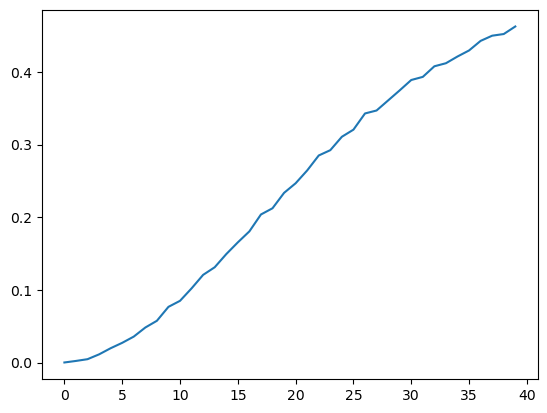

In [ ]:
x,y = mesh.X



stepSize = 0.05
slides = [i*stepSize for i in range(int(2/stepSize))]


functions = [
    1/stepSize * (1 - v.sym[0]) * sympy.Piecewise(
        (1,  sympy.And( (s < x), (x<=s + stepSize))  ),
        (0, True)


    ) for s in slides

]

integrals = [uw.maths.Integral(mesh=mesh, fn=f) for f in functions]
results = [i.evaluate() for i in integrals]
print(results)

import matplotlib.pyplot as plt
plt.plot(results)


##integral = uw.maths.Integral(mesh=mesh, fn=f)
##integral.evaluate()

In [ ]:
slides[-1]

1.9500000000000002

In [ ]:
stokes.bodyforce 
## good

Matrix([[0, 0]])